In [1]:
# Import needed libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Load the dataset
file_path = 'smoking_health_data_final.csv'
data = pd.read_csv(file_path)

# Display first 5 tuples
data.head()

,age,sex,current_smoker,heart_rate,blood_pressure,cigs_per_day,chol
0,54,male,yes,95,110/72,NaN,219.0
1,45,male,yes,64,121/72,NaN,248.0
2,58,male,yes,81,127.5/76,NaN,235.0
3,42,male,yes,90,122.5/80,NaN,225.0
4,42,male,yes,62,119/80,NaN,226.0


In [2]:
# Preprocess the data

# Fill missing values in 'cigs_per_day' with 0
data['cigs_per_day'].fillna(0, inplace=True)

# Split 'blood_pressure' into systolic and diastolic
data[['systolic_bp', 'diastolic_bp']] = data['blood_pressure'].str.split('/', expand=True)
data['systolic_bp'] = pd.to_numeric(data['systolic_bp'])
data['diastolic_bp'] = pd.to_numeric(data['diastolic_bp'])

# Drop original 'blood_pressure' column
data.drop('blood_pressure', axis=1, inplace=True)

# Fill missing cholesterol values with the mean
data['chol'].fillna(data['chol'].mean(), inplace=True)

# Encode categorical data: 'sex' and 'current_smoker'
data['sex'] = data['sex'].map({'male': 1, 'female': 0})
data['current_smoker'] = data['current_smoker'].map({'yes': 1, 'no': 0})

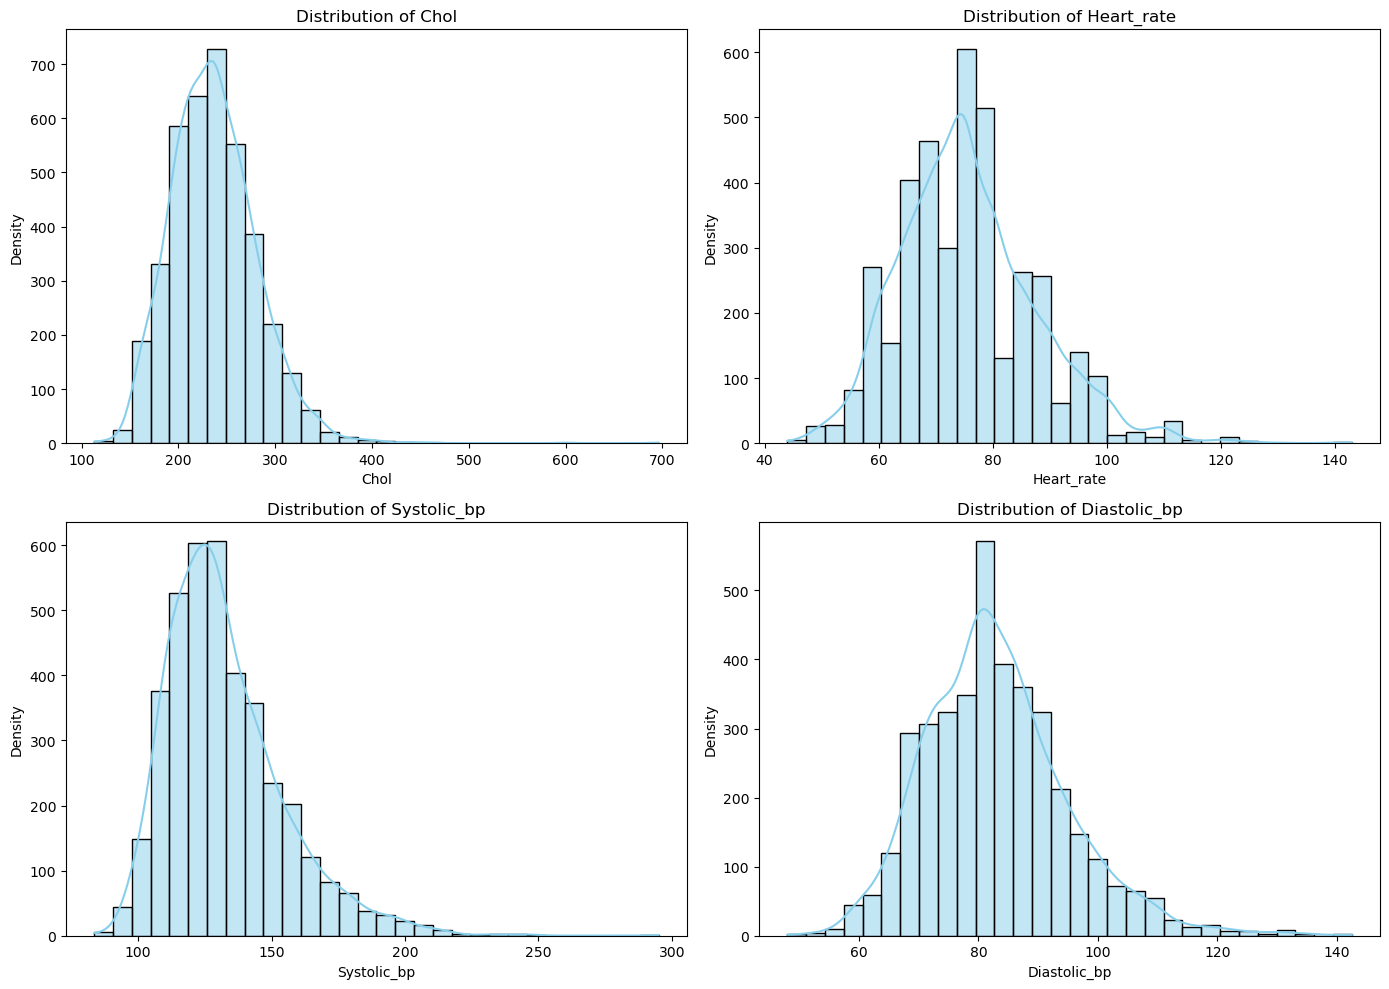

In [3]:
# Distribution of Key Features (Histogram for Cholesterol, Heart Rate, Systolic BP, Diastolic BP)
features_to_plot = ['chol', 'heart_rate', 'systolic_bp', 'diastolic_bp']
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(data[feature], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {feature.capitalize()}')
    plt.xlabel(feature.capitalize())
    plt.ylabel('Density')
plt.tight_layout()
plt.show()

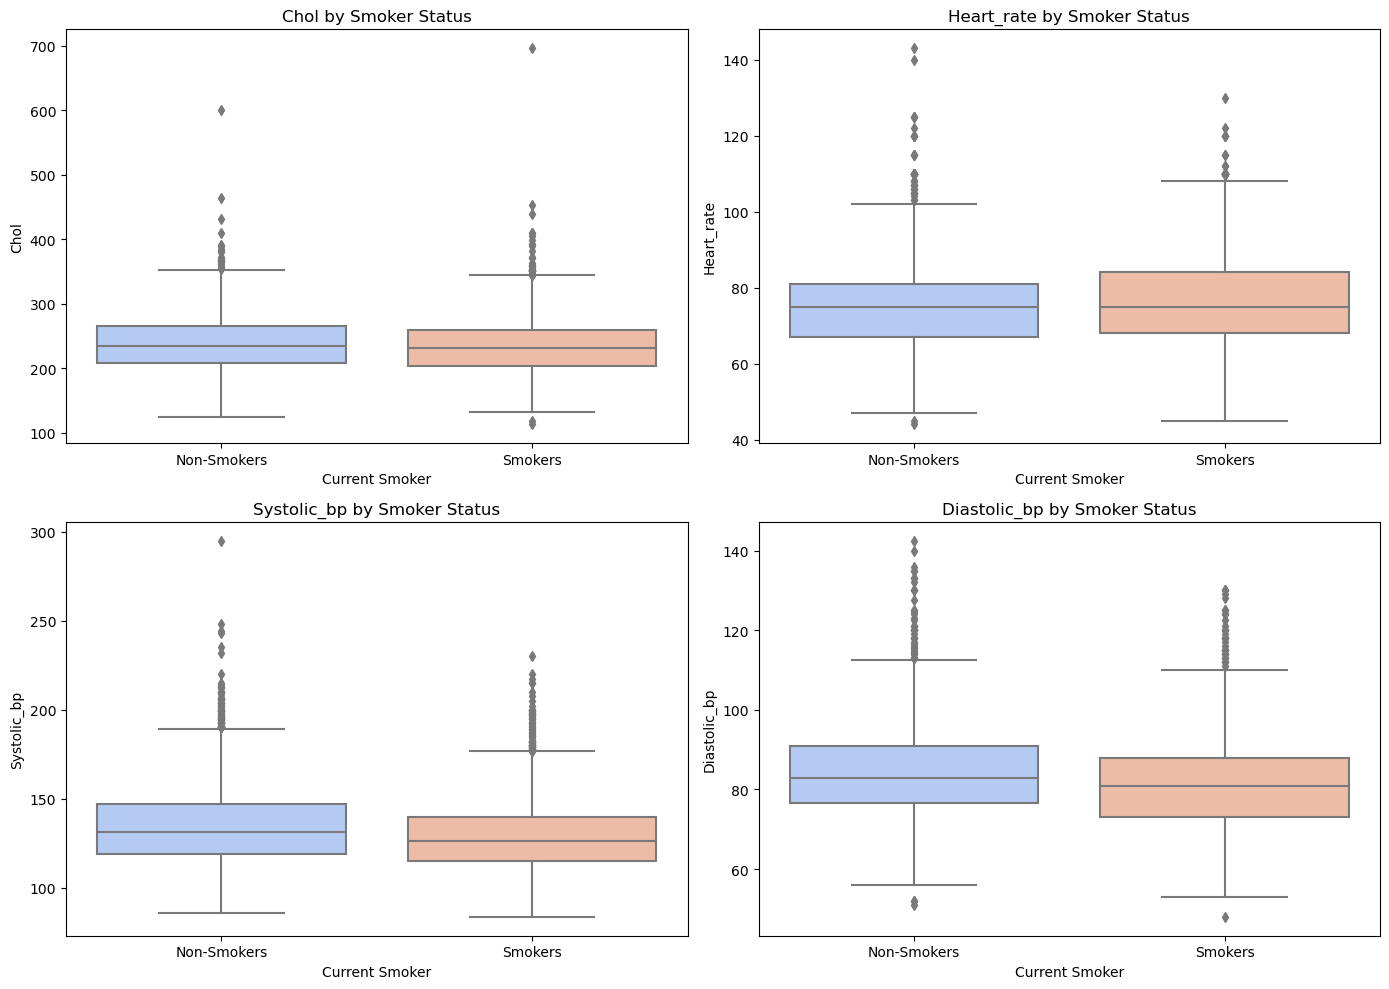

In [4]:
# Boxplots for Feature Distributions by Smoker Status
plt.figure(figsize=(14, 10))
for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x='current_smoker', y=feature, data=data, palette='coolwarm')
    plt.title(f'{feature.capitalize()} by Smoker Status')
    plt.xlabel('Current Smoker')
    plt.ylabel(feature.capitalize())
    plt.xticks([0, 1], ['Non-Smokers', 'Smokers'])
plt.tight_layout()
plt.show()

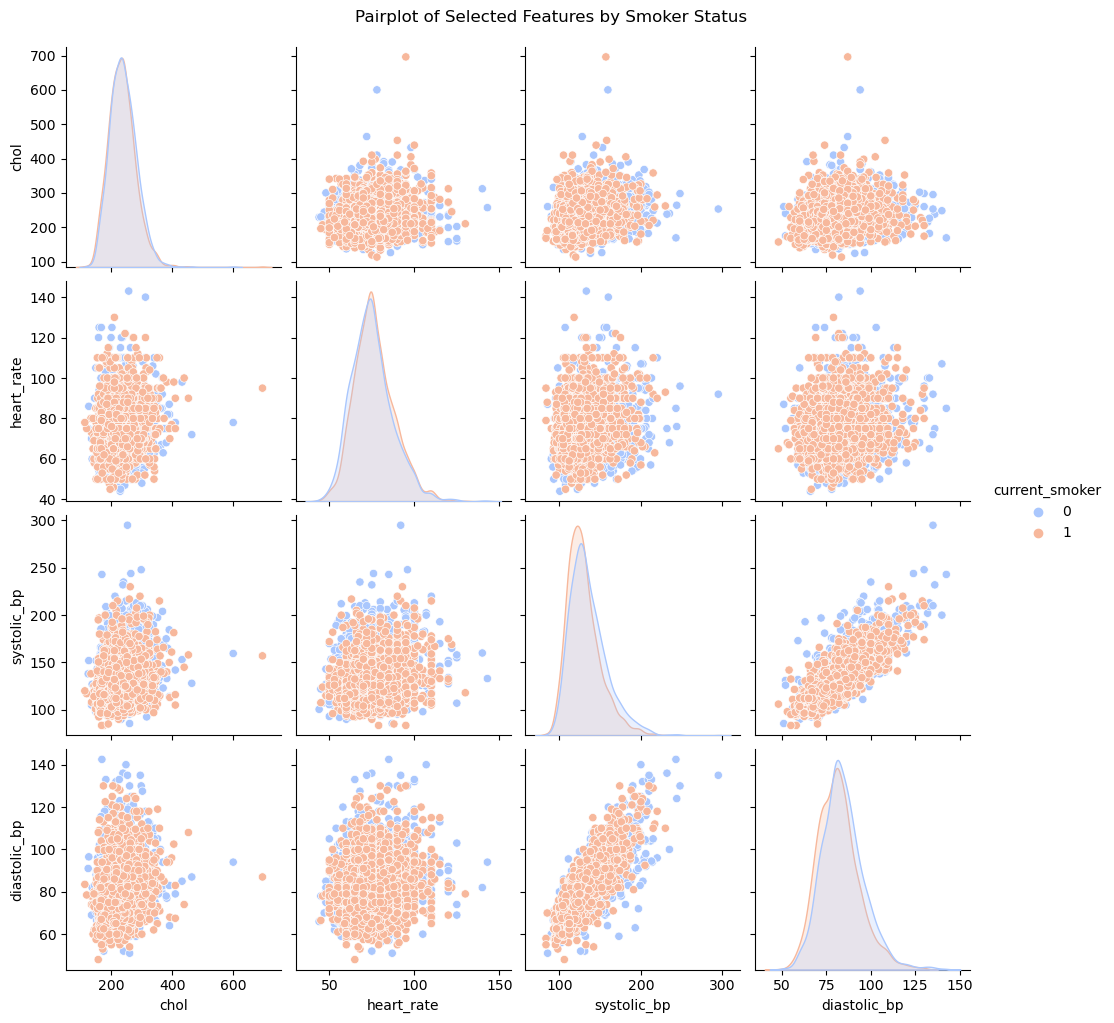

In [5]:
# Pairplot of Features by Smoker Status
sns.pairplot(data, hue='current_smoker', palette='coolwarm', vars=['chol', 'heart_rate', 'systolic_bp', 'diastolic_bp'])
plt.suptitle('Pairplot of Selected Features by Smoker Status', y=1.02)
plt.show()

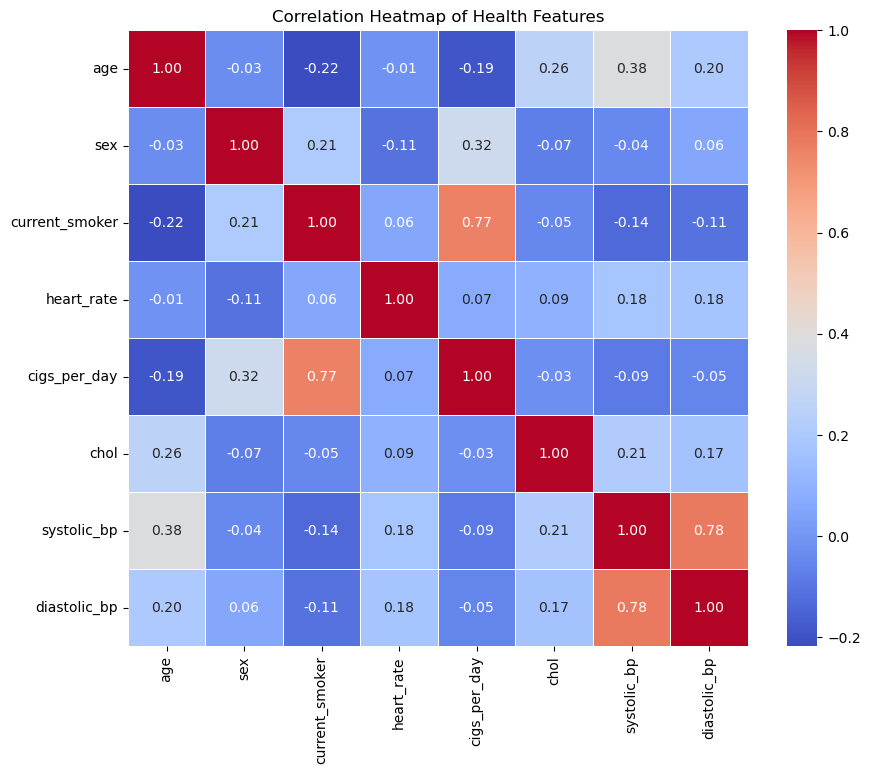

In [6]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Health Features')
plt.show()

In [7]:
# Split the data into features (X) and target (y)
X = data.drop(columns=['current_smoker'])
y = data['current_smoker']

In [8]:
# Create a holdout set to test final model on
X_train_val, X_holdout, y_train_val, y_holdout = train_test_split(X, y, test_size=0.1, random_state=42)

In [9]:
# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

In [10]:
# Build a neural network using TensorFlow/Keras
def build_model(input_shape):
    model = Sequential()
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(16, activation='relu')) # Hidden Layer 1 with 16 nodes and ReLU as activation function
    model.add(Dense(8, activation='relu')) # Hidden Layer 2 with 8 nodes and ReLU as activation function
    model.add(Dense(1, activation='sigmoid')) # Output Layer with 1 node and Sigmoid as activation function
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [11]:
# Plot learning curves
def plot_learning_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

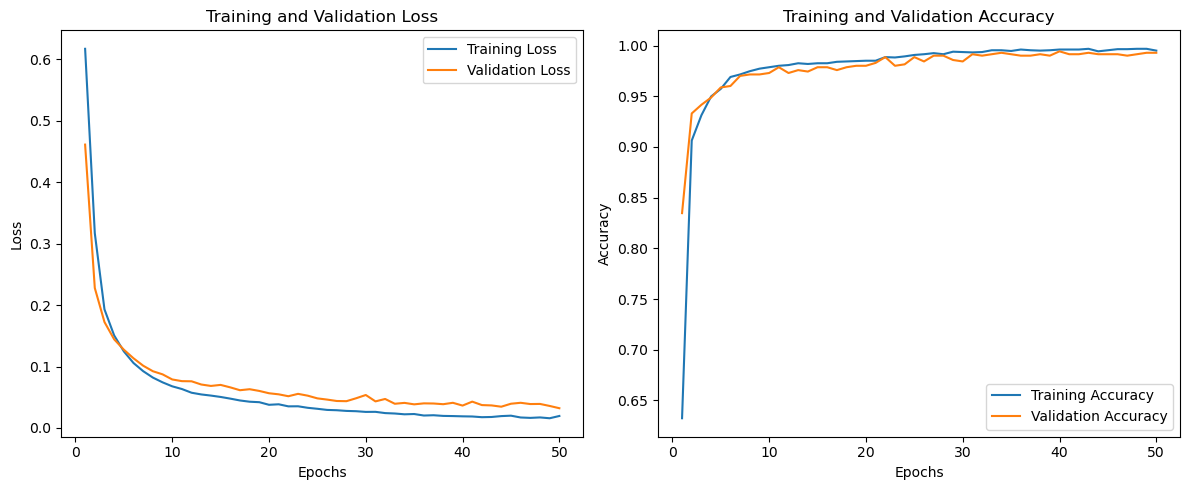

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


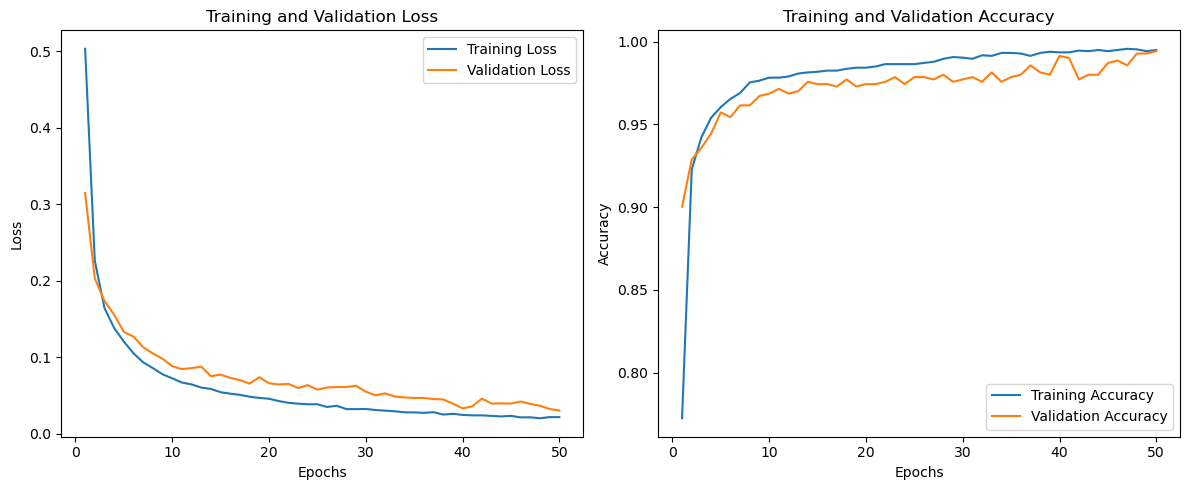

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


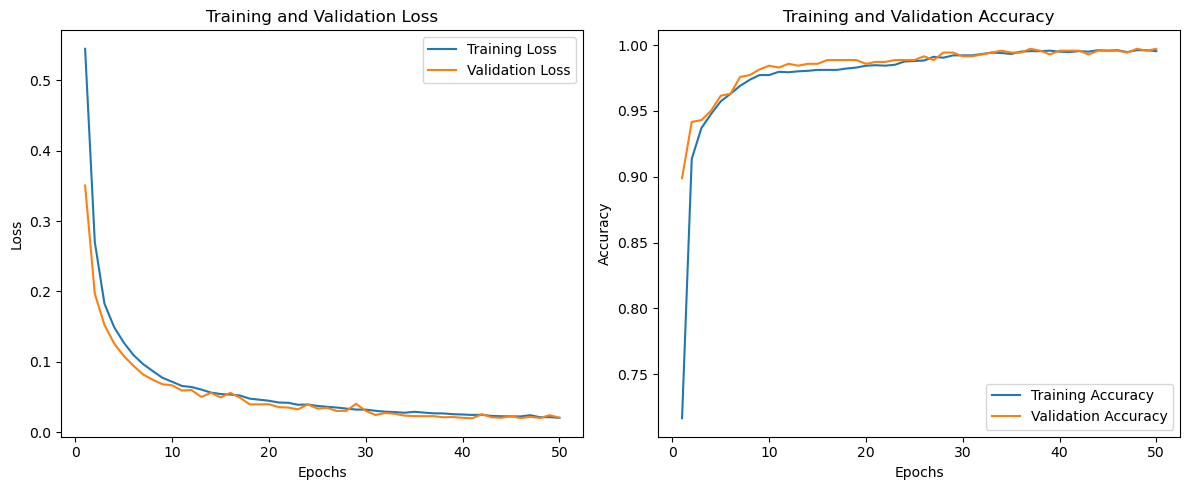

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


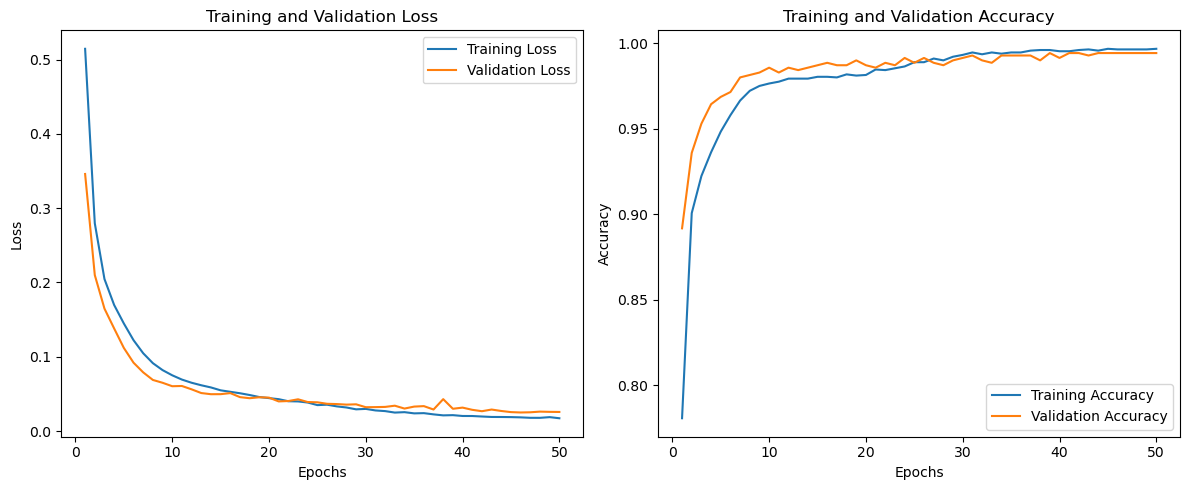

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


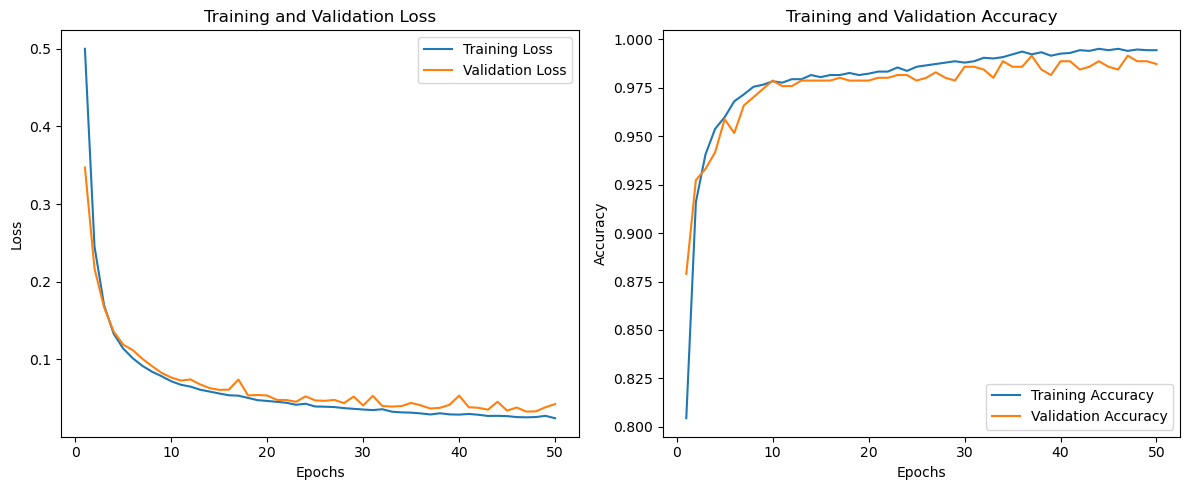

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [12]:
# Train and evaluate using cross-validation on the training/validation set
for train_index, val_index in kf.split(X_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    # Standardize the features (fit only on training data)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model = build_model(X_train_scaled.shape[1])
    
    # Train the model and capture the history
    history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=10, validation_data=(X_val_scaled, y_val), verbose=0)

    # Visualize learning curves for this fold
    plot_learning_curves(history)
    
    # Predict on the validation set
    y_pred = (model.predict(X_val_scaled) > 0.5).astype("int32")
    
    # Evaluation metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    # Store results
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

In [13]:
# Average metrics
avg_accuracy = np.mean(accuracy_list)
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1 = np.mean(f1_list)

# Print evaluation results
print(f'Average Accuracy: {avg_accuracy:.4f}')
print(f'Average Precision: {avg_precision:.4f}')
print(f'Average Recall: {avg_recall:.4f}')
print(f'Average F1 Score: {avg_f1:.4f}')

Average Accuracy: 0.9932
Average Precision: 0.9995
Average Recall: 0.9868
Average F1 Score: 0.9931


In [14]:
# Standardize the holdout set using the same scaler fitted on the training set
scaler_final = StandardScaler()
X_train_final_scaled = scaler_final.fit_transform(X_train_val)
X_holdout_scaled = scaler_final.transform(X_holdout)

# Build and train the final model using the entire training/validation set
model_final = build_model(X_train_final_scaled.shape[1])
history_final = model_final.fit(X_train_final_scaled, y_train_val, epochs=50, batch_size=10, verbose=0)

# Predict on the holdout set
y_pred_holdout = (model_final.predict(X_holdout_scaled) > 0.5).astype("int32")

# Step 4: Evaluate the performance on the holdout set
print("Confusion Matrix on Holdout Set:")
print(confusion_matrix(y_holdout, y_pred_holdout))

print("Classification Report on Holdout Set:")
print(classification_report(y_holdout, y_pred_holdout))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Confusion Matrix on Holdout Set:
[[211   0]
 [  3 176]]
Classification Report on Holdout Set:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       211
           1       1.00      0.98      0.99       179

    accuracy                           0.99       390
   macro avg       0.99      0.99      0.99       390
weighted avg       0.99      0.99      0.99       390



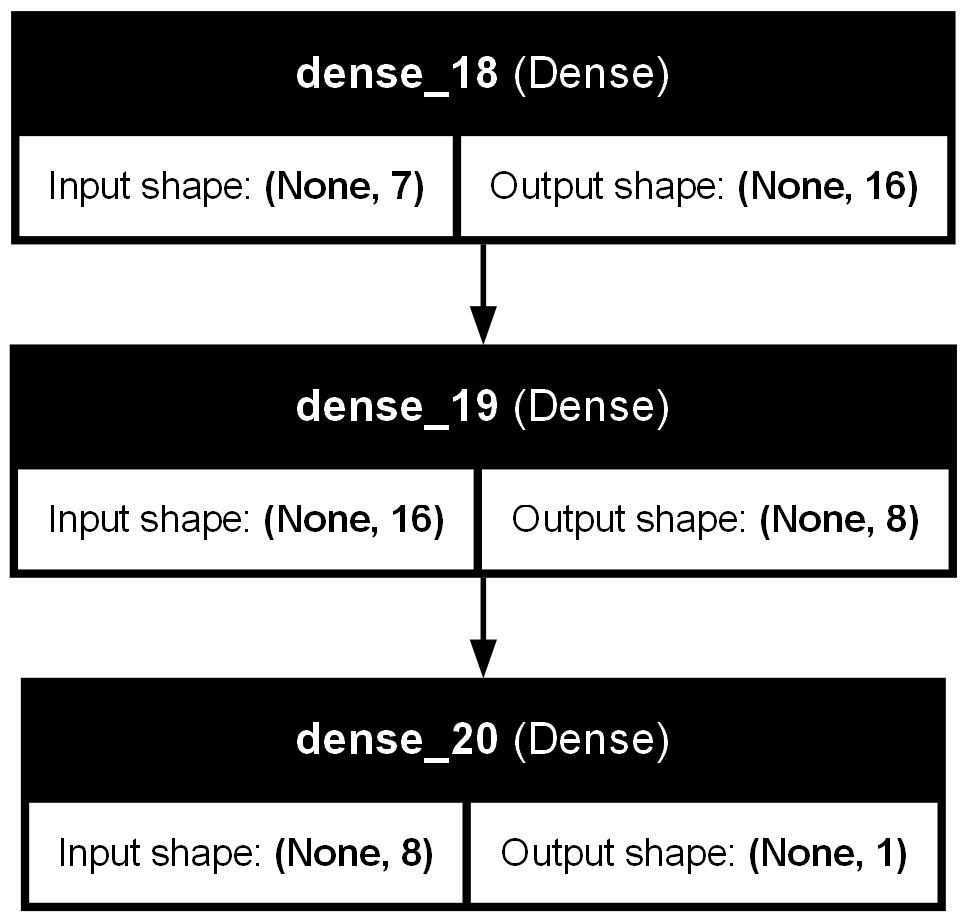

In [15]:
from tensorflow.keras.utils import plot_model

# Assuming the neural network model is created as follows:
model = build_model(input_shape=X_train_val.shape[1])

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the image in the notebook
from IPython.display import Image
Image(filename='model_architecture.png')

